# Show plots of mutation locations throughout the genomes

In [39]:
%run "Header.ipynb"

In [ ]:
%run "LoadMutationJSONData.ipynb"

In [7]:
import skbio
from parse_sco import parse_sco

## Parameters of the diversity index: $p$ and $m$

See paper for description. These are currently copied from the diversity index notebook; ideally, should be loaded from the same place I guess.

In [4]:
m = 5

percentages = [50, 25, 10, 5, 2, 1, 0.5, 0.25, 0.1, 0.05]

p2pct = {p: p / 100 for p in percentages}
p2mincov = {p: m / p2pct[p] for p in percentages}

On seq edge_6104...
On seq edge_1671...
On seq edge_2358...


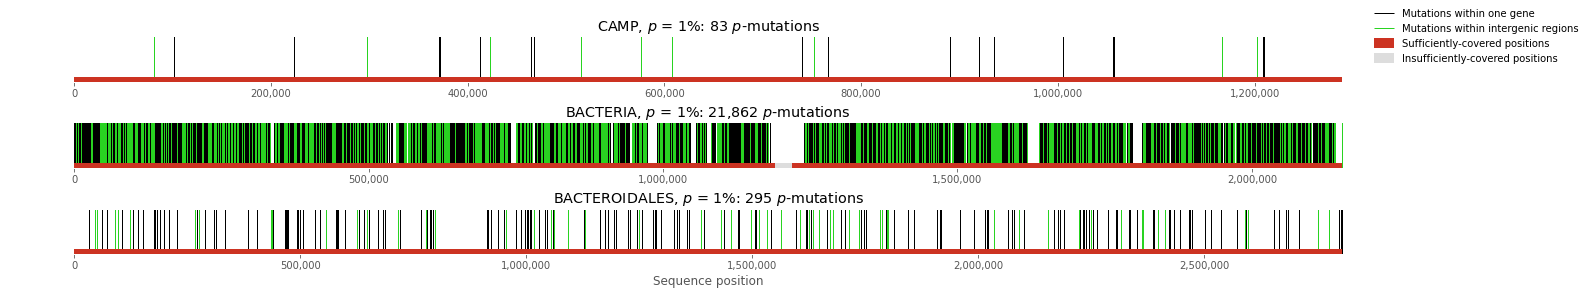

In [48]:
fig, ax = pyplot.subplots(3, 1, gridspec_kw={"hspace": 0.9})

p = 1
for si, seq in enumerate(SEQS):
    print(f"On seq {seq}...")
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    sequence = str(skbio.DNA.read(f"../seqs/{seq}.fasta"))
    positions = range(1, seq2len[seq] + 1)

    num_p_muts = 0
    within_gene_muts = []
    multi_gene_muts = []
    intergenic_muts = []
    
    pos_to_genes = get_parent_gene_info_of_many_positions(1, seq2len[seq], genes_df)
    
    sufficiently_covered_positions = []
    insufficiently_covered_positions = []
    
    for pos in positions:
        cov = seq2pos2totalcov[seq][str(pos)]
        if cov >= p2mincov[p]:
            
            # Only call mutations based on individual nt mutations, not aggregates. Similar to diversity index
            # computation.
            nonmatches = set("ACGT") - set(sequence[pos - 1])
            alt_freqs = seq2pos2mismatches[seq][str(pos)]
            for alt in alt_freqs:
                if (alt_freqs[alt] / cov) > p2pct[p]:
                    num_genes = len(pos_to_genes[pos])
                    if num_genes == 0:
                        intergenic_muts.append(pos)
                    else:
                        within_gene_muts.append(pos)
                    num_p_muts += 1
                    break
            sufficiently_covered_positions.append(pos)
        else:
            insufficiently_covered_positions.append(pos)            
      
    if seq == "edge_6104":
        wgm_label = "Mutations within one gene"
        igm_label = "Mutations within intergenic regions"
        sc_label = "Sufficiently-covered positions"
        ic_label = "Insufficiently-covered positions"
    else:
        wgm_label = igm_label = sc_label = ic_label = None
        
    if seq == "edge_2358":
        ax[si].set_xlabel("Sequence position")
        
    # Draw vertical lines indicating called p-mutations
    ax[si].vlines(within_gene_muts, 0, 1, color="#000000", linewidth=1, label=wgm_label)
    ax[si].vlines(intergenic_muts, 0, 1, color=cp2color[4], linewidth=1, label=igm_label)
            
    # Draw horizontal lines indicating sufficiently and insufficiently-covered positions
    for type_of_positions, color, label in (
        (sufficiently_covered_positions, "#cc3322", sc_label),
        (insufficiently_covered_positions, "#dddddd", ic_label)
    ):
        runs = convert_to_runs(type_of_positions)
        run_starts = [r[0] for r in runs]
        run_ends = [r[1] for r in runs]
        ax[si].hlines([0] * len(run_starts), run_starts, run_ends, color=color, linewidth=10, label=label)
    
    ax[si].set_title(f"{seq2name[seq]}, $p$ = {p}%: {num_p_muts:,} $p$-mutations")
    
    use_thousands_sep(ax[si].xaxis)
    
    # Hide the y-axis labels since they don't really matter here: https://stackoverflow.com/a/2176591
    ax[si].yaxis.set_visible(False)
    
    ax[si].set_ylim(-0.001, 1)
    
    # Make the plot white: https://stackoverflow.com/a/4708018
    ax[si].patch.set_facecolor("None")
    ax[si].patch.set_edgecolor("None")
    ax[si].patch.set_alpha(0)
    
fig.legend(facecolor="white", edgecolor="white")
fig.set_size_inches(25, 4)